**Imports and Basic Setup**

In [22]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

**Data Generation with GMM**

In [2]:
def generate_data_from_gmm(num_samples, pdf_params):
    """Generates synthetic data from a Gaussian Mixture Model (GMM)."""
    samples = []
    labels = []
    for _ in range(num_samples):
        # Sample class label according to the class prior probabilities
        component = np.random.choice(len(pdf_params['priors']), p=pdf_params['priors'])
        mean = pdf_params['mu'][component]
        cov = pdf_params['Sigma'][component]

        # Sample from the multivariate normal distribution
        sample = np.random.multivariate_normal(mean, cov)
        samples.append(sample)
        labels.append(component)

    return np.array(samples), np.array(labels)

**Data Distribution**

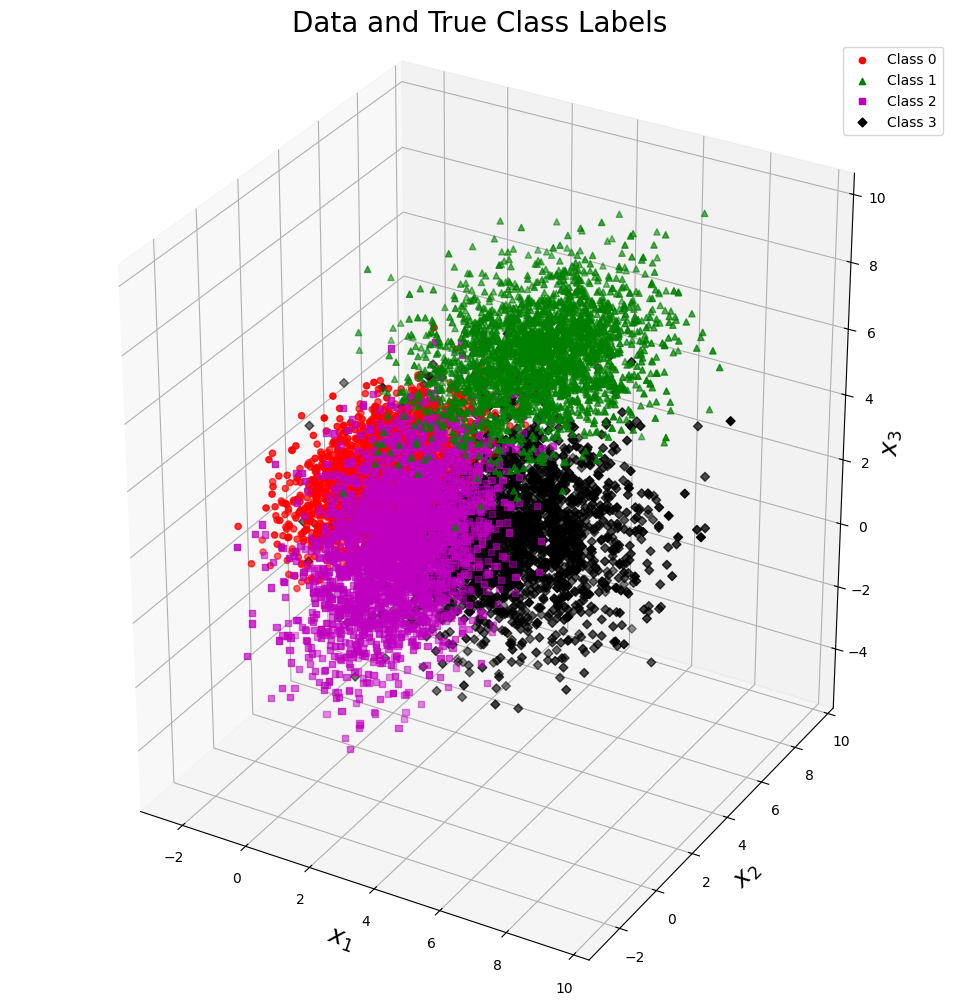

In [12]:
# Number of classes
C = 4
# Parameters for the Gaussian Mixture Model
gmm_params = {
    'priors': np.ones(C) / C,  # uniform prior
    'mu': np.array([[1, 2, 3],
                    [4, 5, 6],
                    [1.5, 2, 1],
                    [3.5, 4, 1]]),  # Gaussian distributions means
    'Sigma': np.array([[[0.6, 0.5, 0.3],
                        [0.5, 1.2, 0.2],
                        [0.3, 0.2, 1.1]],

                       [[2.1, 0.1, 0.4],
                        [0.1, 2.2, 0.3],
                        [0.4, 0.3, 1.1]],

                       [[1.1, 0.2, 0.5],
                        [0.2, 2.1, 0.3],
                        [0.5, 0.3, 3.2]],

                       [[3.1, 0.3, 0.1],
                        [0.3, 1.2, 0.4],
                        [0.1, 0.4, 2.1]]])  # Gaussian distributions covariance matrices
}

# Generate data
num_samples = 10000
X, labels = generate_data_from_gmm(num_samples, gmm_params)

# Plot the data and their true labels
fig = plt.figure(figsize=(10, 10))
ax_raw = fig.add_subplot(111, projection='3d')

# Define colors and markers for each class
class_styles = {'Class 0': {'color': 'r', 'marker': 'o'},
                'Class 1': {'color': 'g', 'marker': '^'},
                'Class 2': {'color': 'm', 'marker': 's'},  # Changed 'A' to 's' for square
                'Class 3': {'color': 'k', 'marker': 'D'}}

for i in range(C):
    class_label = f"Class {i}"
    style = class_styles[class_label]
    ax_raw.scatter(X[labels == i, 0], X[labels == i, 1], X[labels == i, 2], c=style['color'], marker=style['marker'], label=class_label)

ax_raw.set_xlabel("$x_1$", fontsize=18)
ax_raw.set_ylabel("$x_2$", fontsize=18)
ax_raw.set_zlabel("$x_3$", fontsize=18)
ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))
plt.title("Data and True Class Labels", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

**MLP Structure**

In [10]:
class TwoLayerMLP(nn.Module):
    # Two-layer neural network class
    def __init__(self, input_size, P, C):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer mapping from input_size -> P
        self.input_fc = nn.Linear(input_size, P)
        # Output layer again fully connected mapping from P -> C
        self.output_fc = nn.Linear(P, C)

    def forward(self, X):
        # X = [batch_size, input_dim]
        X = self.input_fc(X)
        # ReLU activation
        X = F.relu(X)
        # X = [batch_size, P]
        y = self.output_fc(X)
        return y

**Generate Data**

In [13]:
# Number of training input samples for experiments
N_train_sample = [100, 500, 1000, 5000, 10000]

# Number of test samples for experiments
N_test_sample = 100000

# Lists to hold the corresponding input matrices, target vectors and sample label counts per training set
train_inputs = []
train_targets = []
for sample_size in N_train_sample:
    print("Generating the training data set; Sample_size = {}".format(sample_size))

    # Generate data for the given sample size
    X_i, y_i = generate_data_from_gmm(sample_size, gmm_params)

    # Add to lists
    train_inputs.append(X_i)
    train_targets.append(y_i)

print("Generating the test set; Sample Size = {}".format(N_test_sample))
X_test, y_test = generate_data_from_gmm(N_test_sample, gmm_params)

print("All datasets generated!")

Generating the training data set; Sample_size = 100
Generating the training data set; Sample_size = 500
Generating the training data set; Sample_size = 1000
Generating the training data set; Sample_size = 5000
Generating the training data set; Sample_size = 10000
Generating the test set; Sample Size = 100000
All datasets generated!


**Theoretically Optimal Classifier**

In [14]:
# Conditional likelihoods of each x given each class, shape (C, N)
class_cond_likelihoods = np.array([mvn.pdf(X_test, gmm_params['mu'][i], gmm_params['Sigma'][i]) for i in range(C)])

# Make decisions by selecting the class with the highest likelihood for each sample
decisions = np.argmax(class_cond_likelihoods, axis=0)

# Count misclassified samples
misclassified_samples = sum(decisions != y_test)

# Calculate the minimum probability of error on the test set using the true data PDF
min_prob_error = (misclassified_samples / N_test_sample)

print("Probability of Error on the Test Set using True Data Probability Density Function: {:.4f}".format(min_prob_error))

Probability of Error on the Test Set using True Data Probability Density Function: 0.1713


**Model Order Selection**

In [16]:
def model_train(model, training_data, training_labels, optimizer, criterion=nn.CrossEntropyLoss(), num_epochs=100):
    # Set the model to training mode
    model.train()

    # Optimize the model, e.g., a neural network
    for epoch in range(num_epochs):
        # Get model predictions (probabilities for each class)
        outputs = model(training_data)
        # Criterion computes the cross-entropy loss between input and target
        loss = criterion(outputs, training_labels)
        # Zero the gradients before backpropagation
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()

    return model, loss

def predict_with_models(model, data):
    # Set the evaluation mode
    # Similar idea to model.train(), set a flag to let network know you're in "inference" mode
    model.eval()

    # Disabling gradient calculation is useful for inference
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        # Obtain prediction from the models
        predicted_labels = model(data)

    # Back to numpy
    predicted_labels = predicted_labels.detach().numpy()

    return np.argmax(predicted_labels, axis=1)

In [20]:
def k_fold_cv_perceptrons(K, perceptron_options, input_data, labels):
    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True)

    # Allocate space for cross-validation errors
    error_valid_mk = np.zeros((len(perceptron_options), K))

    # Track model index
    perceptron_index = 0

    # STEP 2: Iterate over all perceptron options
    for perceptrons in perceptron_options:
        k = 0
        for train_indices, valid_indices in kf.split(input_data):
            # Extract the training and validation sets from the K-fold split
            # Convert numpy structures to PyTorch tensors, necessary data types
            X_train_k = torch.FloatTensor(input_data[train_indices])
            y_train_k = torch.LongTensor(labels[train_indices])

            # Create a two-layer perceptron model
            model = TwoLayerMLP(X_train_k.shape[1], perceptrons, C)

            # Stochastic Gradient Descent with learning rate and momentum hyperparameters
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

            # Train model
            model, _ = model_train(model, X_train_k, y_train_k, optimizer)

            X_valid_k = torch.FloatTensor(input_data[valid_indices])
            y_valid_k = labels[valid_indices]

            # Evaluate the neural network on the validation fold
            predictions = predict_with_models(model, X_valid_k)

            # Retain the probability of error estimates
            error_valid_mk[perceptron_index, k] = np.sum(predictions != y_valid_k) / len(y_valid_k)
            k += 1
        perceptron_index += 1

    # STEP 3: Compute the average prob. error (across K folds) for that model
    error_valid_m = np.mean(error_valid_mk, axis=1)

    # Return the optimal choice of P* and prepare to train selected model on entire dataset
    optimal_P = perceptron_options[np.argmin(error_valid_m)]

    return optimal_P, error_valid_m

	# of Training Samples 	Best # of Perceptrons 	Pr(error)
		 100 		 128 		 0.240
		 500 		 256 		 0.230
		 1000 		 512 		 0.190
		 5000 		 512 		 0.189
		 10000 		 512 		 0.178


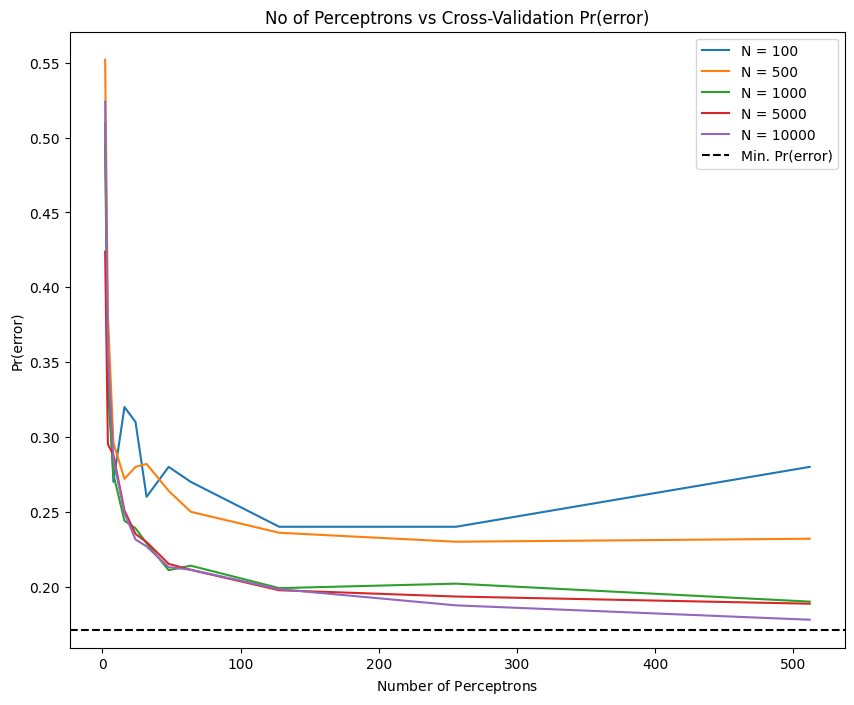

In [23]:
# Number of folds for CV
K = 10

# List of candidate numbers of perceptrons for MLPs
perceptron_options = [2, 4, 8, 16, 24, 32, 48, 64, 128, 256, 512]
# List of best number of perceptrons for MLPs per training set
perceptron_best_list = []

fig, ax = plt.subplots(figsize=(10, 8))

print("\t# of Training Samples \tBest # of Perceptrons \tPr(error)")
for i in range(len(train_inputs)):
    best_perceptrons, P_CV_err = k_fold_cv_perceptrons(K, perceptron_options, train_inputs[i], train_targets[i])
    perceptron_best_list.append(best_perceptrons)
    print("\t\t %d \t\t %d \t\t %.3f" % (N_train_sample[i], best_perceptrons, np.min(P_CV_err)))
    ax.plot(perceptron_options, P_CV_err, label="N = {}".format(N_train_sample[i]))

plt.axhline(y=min_prob_error, color="black", linestyle="--", label="Min. Pr(error)")
ax.set_title("No of Perceptrons vs Cross-Validation Pr(error)")
ax.set_xlabel(r"$\text{Number of Perceptrons}$")
ax.set_ylabel("Pr(error)")
ax.legend()
plt.show()

**Model Training**

In [24]:
# List of trained MLPs for later testing
trained_mlps = []
# Number of times to re-train the same model with random re-initializations
num_restarts = 10

for i in range(len(train_inputs)):
    print("Training model for N = {}".format(train_inputs[i].shape[0]))
    X_i = torch.FloatTensor(train_inputs[i])
    y_i = torch.LongTensor(train_targets[i])

    restart_mlps = []
    restart_losses = []
    # Remove chances of falling into suboptimal local minima
    for r in range(num_restarts):
        model = TwoLayerMLP(X_i.shape[1], perceptron_best_list[i], C)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        # Train model
        model, loss = model_train(model, X_i, y_i, optimizer)
        restart_mlps.append(model)
        restart_losses.append(loss.detach().item())

    # Add best model from multiple restarts to the list
    trained_mlps.append(restart_mlps[np.argmin(restart_losses)])

Training model for N = 100
Training model for N = 500
Training model for N = 1000
Training model for N = 5000
Training model for N = 10000


**Performance Assessment**

Probability of error results summarized below per trained MLP:

	 # of Training Samples 	 Pr(error)
		 100 		 0.202
		 500 		 0.190
		 1000 		 0.182
		 5000 		 0.181
		 10000 		 0.180


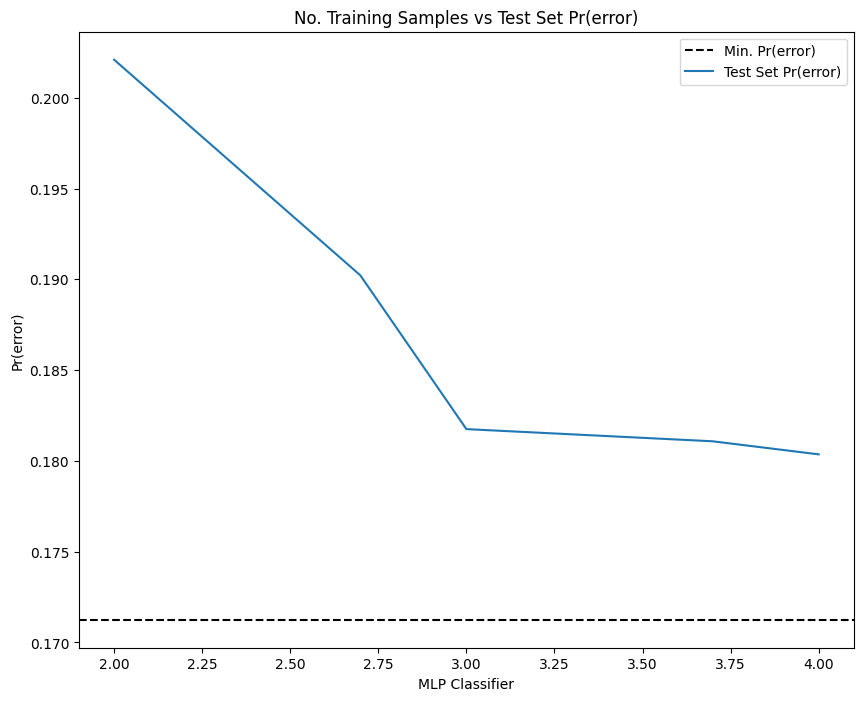

In [25]:
# First convert test set data to tensor suitable for PyTorch models
X_test_tensor = torch.FloatTensor(X_test)
pr_error_list = []

fig, ax = plt.subplots(figsize=(10, 8))

# Estimate Loss (probability of error) for each trained MLP model by testing on the test data set
print("Probability of error results summarized below per trained MLP:\n")
print("\t # of Training Samples \t Pr(error)")
for i in range(len(train_inputs)):
    # Evaluate the neural network on the test set
    predictions = predict_with_models(trained_mlps[i], X_test_tensor)
    # Compute the probability of error estimates
    prob_error = np.sum(predictions != y_test) / len(y_test)
    print("\t\t %d \t\t %.3f" % (N_train_sample[i], prob_error))
    pr_error_list.append(prob_error)

plt.axhline(y=min_prob_error, color="black", linestyle="--", label="Min. Pr(error)")
ax.plot(np.log10(N_train_sample), pr_error_list, label="Test Set Pr(error)")
ax.set_title("No. Training Samples vs Test Set Pr(error)")
ax.set_xlabel("MLP Classifier")
ax.set_ylabel("Pr(error)")

# Uncomment if log scale is required for xticks
# ax.set_xticks(np.log10(N_train_sample))
ax.legend()
plt.show()